<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Timeseries Forecasting with LSTM Neural Networks

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives

- Build a basic LSTM using Keras.
- Train the LSTM model on unemployment data and forecast to future data.

<a id="introduction"></a>
## Introduction
---

Modeling timeseries and forecasting with neural networks is a growing trend. The Long Short Term Memory (LSTM) recurrent neural network architecture is a popular choice when "context" or memory across time is a desired capability of the model.

In this walkthrough/codealong lecture we will be building an LSTM using the Keras framework to forecast stock market timeseries data. 

<a id="a-note-on-the-lesson-content"></a>
### A note on the lesson content

This codealong focuses primarily on the Keras implementation and application of LSTM neural networks. This lecture does not cover:
- The theory behind recurrent neural networks.
- The mathematics or theory behind the architecture of LSTM networks.

There are a variety of great resources to dive deeper into LSTM networks:
- [A beginners guide to recurrent networks and LSTMs](http://deeplearning4j.org/lstm.html#a-beginners-guide-to-recurrent-networks-and-lstms)
- [Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [This tutorial provides a great introduction to building a simple LSTM for timeseries forecasting.](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id="load-the-keras-modules"></a>
## Load the Keras modules
---

Keras is a popular, high-level framework for neural networks in python. It is a "wrapper" on top of lower level backend frameworks: particularly TensorFlow and Theano.

> **Note:** this lesson is written with Keras running on the TensorFlow backend instead of the Theano backend. This does, unfortunately, have an impact on the way the code is written. Theano and TensorFlow have different indexing orders. [To change the backend that Keras runs on, please see this guide in the documentation.](https://keras.io/backend/)

**We need to import four classes from Keras:**

- **`Sequential`** is the model that will house our neural network layers. It stacks together the input, "hidden" and output layers of the network.
- **`Dense`** is a standard fully-connected neural network layer where each node as inputs/output connections to every node in the layers it is connected to.
- **`LSTM`** is the Long Short Term Memory recurrent neural network layer. This will house our LSTM "neurons" or "cells".

We are also importing `MinMaxScaler` from sklearn. Inputs to the LSTM (and neural networks in general) perform better if they are normalized.

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


<a id="prepare-the-unemployment-data-for-timeseries-modeling"></a>
## 1. Prepare the unemployment data for timeseries modeling
---

First we will load quarterly US unemployment data to do some basic forecasting using LSTMs. 

**Load the unemployment data from CSV file and perform any required cleaning.**

In [5]:
data = pd.read_csv('./datasets/seasonally-adjusted-quarterly-us.csv')

In [6]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
data.head(3)

,year_quarter,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667
2,1948Q3,3.767


In [7]:
data = data.drop(174)  # last row not part of CSV

In [8]:
data.index = pd.to_datetime(data['year_quarter']).dt.to_period('Q')
data.drop('year_quarter', inplace=True, axis=1)

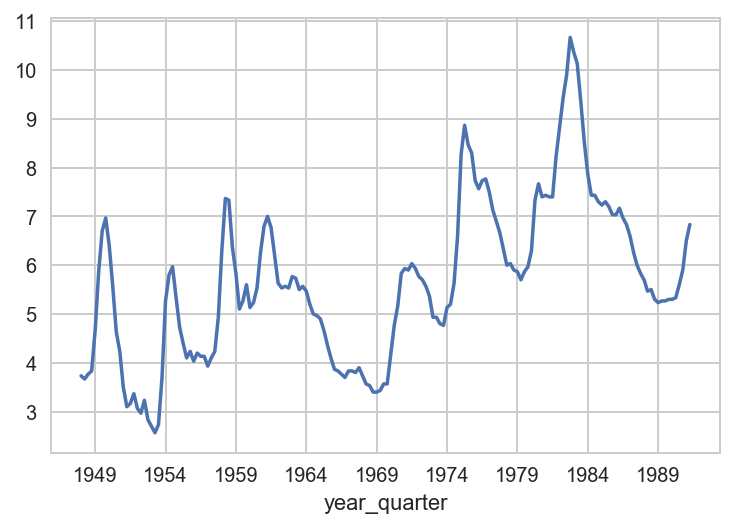

In [10]:
data.unemployment_rate.plot();

<a id="create-the-first-order-differenced-unemployment-rate"></a>
### Create the first-order differenced unemployment rate

In timeseries modeling the raw timeseries is rarely used. Typically we will use the first order differenced timeseries (or further order differences). Technically this differencing is done to ensure that the timeseries is stationary. 

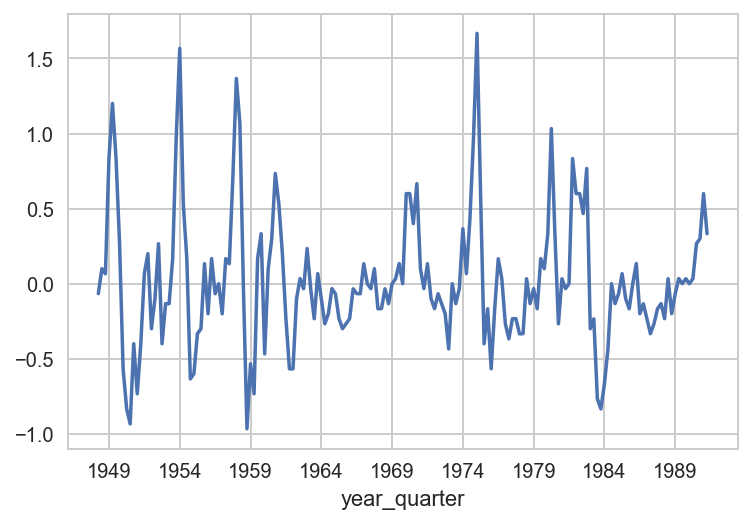

In [11]:
data['udiff'] = data['unemployment_rate'].diff()
data['udiff'].plot();

<a id="normalize-the-differenced-unemployement-data-with-minmaxscaler"></a>
### Normalize the differenced unemployement data with `MinMaxScaler`

We want the rate to be restricted to the range -1 to 1.

> **Note:** the differencing will make the first value of the series a NaN value. Make sure to drop this from the dataset.

In [13]:
urate = data[['udiff']].iloc[1:,:]

mms = MinMaxScaler(feature_range=(-1, 1))
urate = mms.fit_transform(urate)

urate.shape

(173, 1)

<a id="split-the-timeseries-into--traintest-splits"></a>
### Split the timeseries into train/test splits

We don't want a random train/test split in this case. With timeseries data, we are interested in how are model generalizes to future data in particular. Make the test set the second half of the data through time.

In [15]:
# 3 Ys worth of quarterly data
test_size = 12
# the rest
train_size = len(urate) - test_size

train = urate[0:train_size, :]
test = urate[train_size:, :]

train.shape, test.shape

((161, 1), (12, 1))

<a id="write-a-function-to-create-the-predictor-and-target-data"></a>
## 2. Write a function to create the predictor and target data
---

The function will need to create a Y target and X predictor. The X predictor matrix will simply be the shifted versions of Y, our target unemployment timeseries. In other words, we want our features to be previous timesteps of the target data for given lags.

**Make a function with two arguments:**
1. The timeseries data.
2. The number of lags of the timeseries to have as predictors.

The default should create a dataset where X is the unemployment rate a given time (t) and Y is the unemployment rate at the next time (t + 1). At the default lag of 1 X will just be the unemployment timeseries of Y shifted back by 1.

> **Note:** make sure that the output X and Y are of the same length! You will need to slice off a row (at least - depends on the lag order).

In [21]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
        
    y = timeseries[lag:]
    X = pd.DataFrame({'lag' + str(lag - i):timeseries.shift(-i) for i in range(0, lag)})
    X = X.dropna()
    X = X.iloc[:-1, :]
    
    if not as_array:
        return(X, y)
    else:
        return(X.values, y.values)

In [22]:
X, y = create_data(urate[:8], lag=3, as_array=False)

In [23]:
X

,lag1,lag2,lag3
0,-0.216103,-0.190277,-0.316369
1,0.367262,-0.216103,-0.190277
2,0.645272,0.367262,-0.216103
3,0.366502,0.645272,0.367262
4,-0.063426,0.366502,0.645272


<a id="create-training-and-testing-data-for-a-lag-of-"></a>
### Create training and testing data for a lag of 1

Again, this means our X will just have 1 column.

In [24]:
lag = 1
train_X, train_Y = create_data(train, lag)
test_X, test_Y = create_data(test, lag)

In [25]:
test_X.shape

(11, 1)

<a id="reshape-the-data-to-work-with-the-lstm"></a>
## Reshape the data to work with the LSTM
---

The format of data the LSTM expects is:

    [samples, time_steps, features]
    
where

- `samples`: number of observations,
- `time_steps`: number of (lagged) time steps to use in the prediction,
- `features`: number of features/sequences to use in the prediction.
    
This is a 3D matrix.

We have been using 2D predictor matrices for our machine learning algorithms, where our X predictor matrix has been in the form:

    [samples, features]

Since we are working with timeseries (which is the data an LSTM expects), we are now required to provide information about the time.

You can use the `np.reshape()` command to turn your 2D X matrix into a 3D matrix that works for the LSTM matrix. We will talk about the "time step" dimension more down the line. 

> **Note:** In the case of a single lag this time step dimension is redundant. Later on, when we redesign the X matrix so that our individual features have multiple timesteps, this 3D format requirement will be clearer.

In [27]:
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X,
                    (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X,
                   (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((160, 1, 1), (160,), (11, 1, 1), (11,))

1. Read data
2. (optional, but good plan) make your timeseries stationary
3. Scale the data  (e.g. MinMax (for tightness) or SS (not as tight))
4. Create your X matrix of lags and corresponding targets, y
5. Reshape X matrix into a 3D matrix (tensors)
6. Build a model

<a id="constructing-the-keras-model"></a>
## Constructing the Keras model

Our LSTM model will be constructed in three parts.

First initialize the sequential layer-to-layer neural network model:

```python
model = Sequential()
```
    
Add an LSTM layer with 4 blocks/cells/neurons. We specify the `input_shape` to be the same dimensions as our features. You will notice that the `input_shape` below takes a tuple `(None, lag)`. The `None` is a placeholder for the timesteps of our features. By putting `None` we are simply avoiding specifying the timesteps.

```python
model.add(LSTM(num_cells, batch_input_shape=(batch_size, lagged timesteps, features), stateful=True))
```

A few notes to get LSTMs "right":

- `stateful` should be set to `True`: this enables the "long-term" memory of the LSTM,
- the batch_size should be set to 1.

Add the output layer as a layer of one neuron that is fully connected to all of the previous LSTM cells:

```python
model.add(Dense(1))
```

In [32]:
batch_size = 1
# It's recurrent but it's still instantiated as Sequential
model = Sequential()
# Normal range of LSTM units is around 2-10
model.add(LSTM(4,
               batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]),
               stateful=True))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


<a id="fit-the-lstm-model"></a>
### Fit the LSTM model

To fit Keras models, we would typically use something like this:

```python
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=1)
```

For LSTMs, however, we need to "reset the state" between epochs.  This effectively resets the memory of the LSTM between epochs, which are entire sweeps of the timeseries.

```python
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(train_X, train_Y, validation_data=(testX, testY), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()
```

In [33]:
model.compile(loss='mean_squared_error', optimizer='adam')
for epoch in range(30):
    model.fit(train_X, train_Y, validation_data=(test_X, test_Y),
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Train on 160 samples, validate on 11 samples
Epoch 1/1
160/160 [==============================] - 2s 14ms/step - loss: 0.1760 - val_loss: 0.0282
Train on 160 samples, validate on 11 samples
Epoch 1/1
160/160 [==============================] - 1s 5ms/step - loss: 0.1261 - val_loss: 0.0353
Train on 160 samples, validate on 11 samples
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.1207 - val_loss: 0.0363
Train on 160 samples, validate on 11 samples
Epoch 1/1
160/160 [==============================] - 1s 5ms/step - loss: 0.1174 - val_loss: 0.0348
Train on 160 samples, validate on 11 samples
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.1144 - val_loss: 0.0329
Train on 160 samples, validate on 11 samples
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.1116 - val_loss: 0.0309
Train on 160 samples, validate on 11 samples
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.1088 - val_loss

<a id="plot-the-original-data-the-training-predictions-and-the-testing-predictions"></a>
### Plot the original data, the training predictions and the testing predictions

You can predict from a Keras model much like with a sklearn model:

```python
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)
```

Recall, however, that this LSTM is "stateful", meaning you should always begin at the beginning and sweep through your entire time series.  If you repeat this process for new predictions, you should reset the state.

In [35]:
from sklearn.metrics import mean_absolute_error

model.reset_states()

train_prediction = model.predict(train_X, batch_size=batch_size)
test_prediction = model.predict(test_X, batch_size=batch_size)
test_observed = urate[-len(test_prediction):, :]

print('MAE =', mean_absolute_error(test_observed, test_prediction))

MAE = 0.08557450521328457


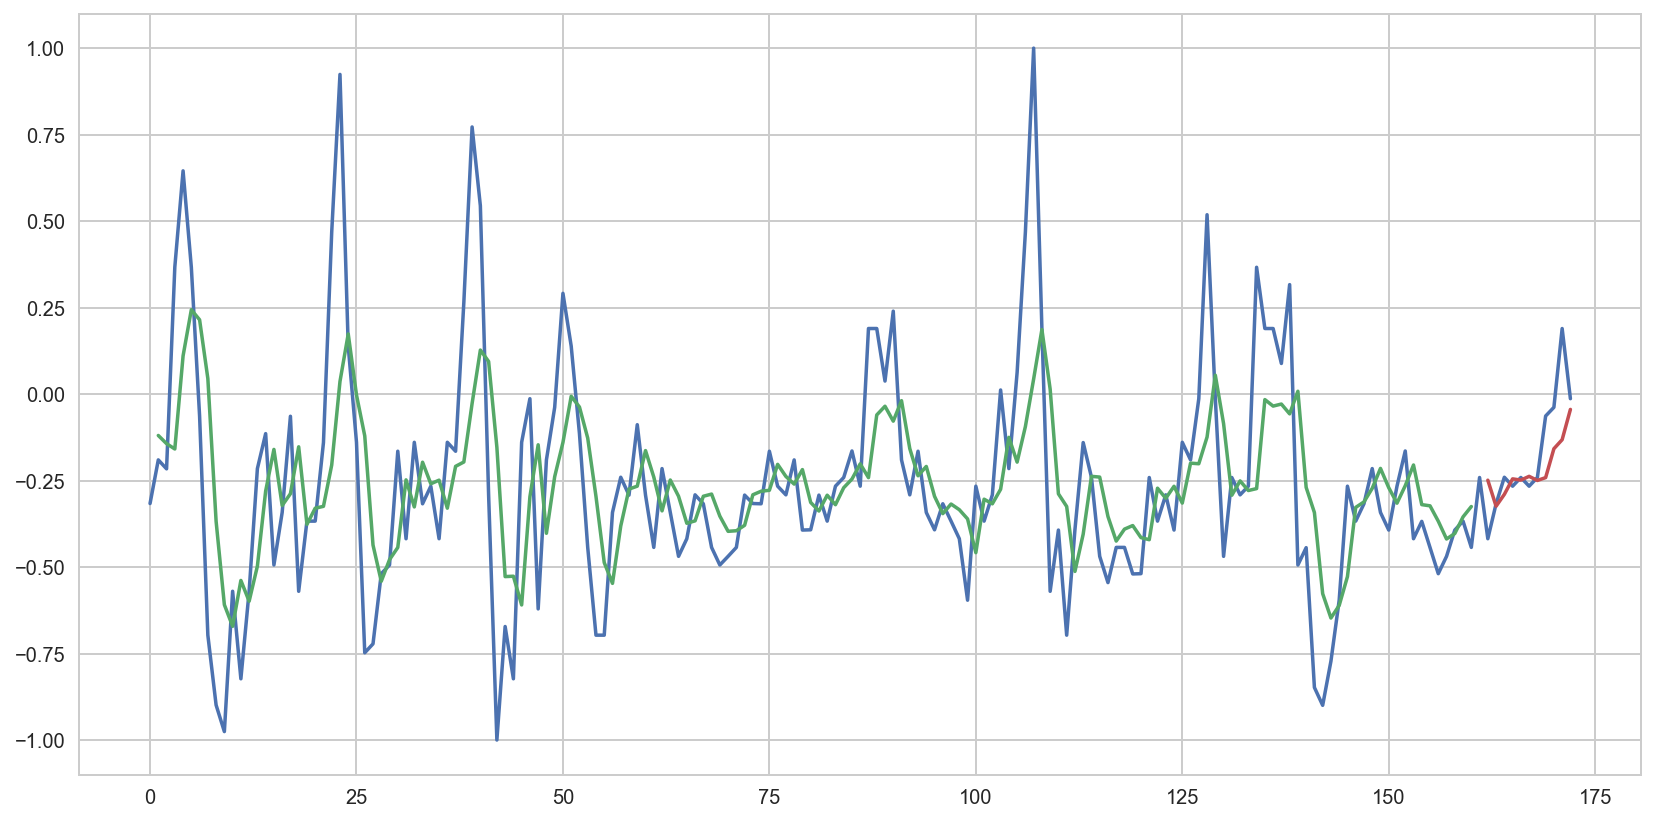

In [39]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(urate)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_prediction)+lag, :] = train_prediction
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(urate)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_prediction):, :] = test_prediction
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

<a id="lstm-with-multiple-lags-as-predictors"></a>
## LSTM with multiple lags as predictors
---

We can instead predict the unemployment rate from not just the rate prior, but the `t-1`, `t-2`, and `t-3` rates.

You can use the function you wrote above to construct a new X and y where X now has 3 predictors according to the different lags.

Create the new Y and X variables below:

In [51]:
lag = 3
train_X, train_y = create_data(train, lag)
test_X, test_y = create_data(test, lag)

#reshape: [samples, lagged time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [52]:
batch_size = 1
model = Sequential()
model.add(LSTM(4,
          batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]),
          stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [53]:
for i in range(20):
    model.fit(train_X, train_y, validation_data=(test_X, test_y),
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Train on 158 samples, validate on 9 samples
Epoch 1/1
158/158 [==============================] - 3s 16ms/step - loss: 0.2453 - val_loss: 0.0305
Train on 158 samples, validate on 9 samples
Epoch 1/1
158/158 [==============================] - 1s 6ms/step - loss: 0.1302 - val_loss: 0.0447
Train on 158 samples, validate on 9 samples
Epoch 1/1
158/158 [==============================] - 1s 6ms/step - loss: 0.1244 - val_loss: 0.0419
Train on 158 samples, validate on 9 samples
Epoch 1/1
158/158 [==============================] - 1s 6ms/step - loss: 0.1213 - val_loss: 0.0390
Train on 158 samples, validate on 9 samples
Epoch 1/1
158/158 [==============================] - 1s 6ms/step - loss: 0.1190 - val_loss: 0.0365
Train on 158 samples, validate on 9 samples
Epoch 1/1
158/158 [==============================] - 1s 7ms/step - loss: 0.1171 - val_loss: 0.0343
Train on 158 samples, validate on 9 samples
Epoch 1/1
158/158 [==============================] - 1s 7ms/step - loss: 0.1153 - val_loss: 0.032

MAE =  0.05998310573100696


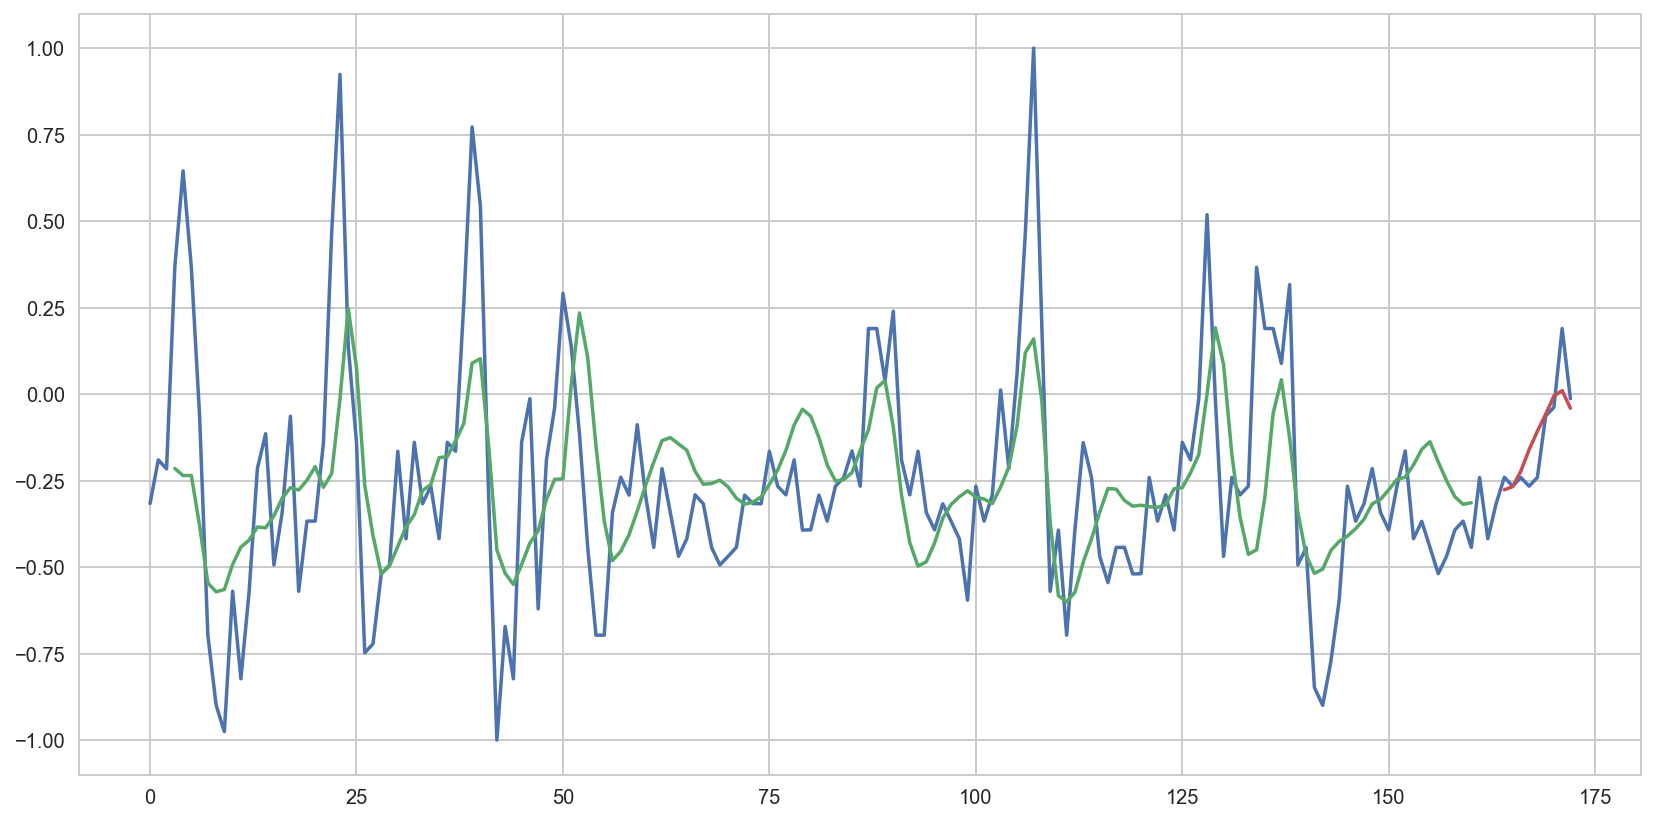

In [54]:
model.reset_states()

train_prediction = model.predict(train_X, batch_size=batch_size)
test_prediction = model.predict(test_X, batch_size=batch_size)
test_observed = urate[-len(test_prediction):, :]

print('MAE = ', mean_absolute_error(test_observed, test_prediction))

# shift train predictions for plotting
train_predict_plot = np.empty_like(urate)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_prediction)+lag, :] = train_prediction
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(urate)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_prediction):, :] = test_prediction
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()